## Class_TEST_K_labels

### Libraries

In [1]:
# !pip install scikit-plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
os.environ["OMP_NUM_THREADS"] = "8"

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

### Data preprocessing

In [3]:
df = pd.read_csv("train_cleaned_kmeans4.csv")
test = pd.read_csv("test_cleaned_kmeans4.csv")

In [4]:
np.unique(test['kmeans.labels_'], return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([1027, 2298,  618, 1057], dtype=int64))

In [5]:
df = df.replace({"explicit": {False:0, True:1}})
test = test.replace({"explicit": {False:0, True:1}})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              15000 non-null  object 
 1   duration_ms       15000 non-null  int64  
 2   explicit          15000 non-null  int64  
 3   popularity        15000 non-null  int64  
 4   artists           15000 non-null  object 
 5   album_name        15000 non-null  object 
 6   danceability      15000 non-null  float64
 7   energy            15000 non-null  float64
 8   key               15000 non-null  int64  
 9   loudness          15000 non-null  float64
 10  speechiness       15000 non-null  float64
 11  acousticness      15000 non-null  float64
 12  instrumentalness  15000 non-null  float64
 13  liveness          15000 non-null  float64
 14  valence           15000 non-null  float64
 15  tempo             15000 non-null  float64
 16  time_signature    15000 non-null  float6

### Preparing the training data

In [7]:
df.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,kmeans.labels_
0,Long Road,241760,0,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,j-dance,3
1,"Daniâl My Son, Where Did You Vanish?",444000,0,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,iranian,2
2,Ondskapens Galakse,333506,0,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,black-metal,3
3,Can't Look Away,269800,0,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,bluegrass,1
4,Thunderground,307651,0,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,happy,1


In [8]:
df = df.replace({"kmeans.labels_": {0:"mid-low energy, low inst", 1:"mid-high energy, low inst", 2:"mid-low energy, high inst", 3:"mid-high energy, high inst"}})

In [9]:
df.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,kmeans.labels_
0,Long Road,241760,0,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,j-dance,"mid-high energy, high inst"
1,"Daniâl My Son, Where Did You Vanish?",444000,0,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,iranian,"mid-low energy, high inst"
2,Ondskapens Galakse,333506,0,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,black-metal,"mid-high energy, high inst"
3,Can't Look Away,269800,0,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,bluegrass,"mid-high energy, low inst"
4,Thunderground,307651,0,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,happy,"mid-high energy, low inst"


In [10]:
X_train = df.iloc[:, [1,2,6,7,8,9,10,11,12,13,14,15,16]].values
y_train = np.array(df.iloc[:, [-1]].values)

In [11]:
np.unique(y_train, return_counts=True)

(array(['mid-high energy, high inst', 'mid-high energy, low inst',
        'mid-low energy, high inst', 'mid-low energy, low inst'],
       dtype=object),
 array([3191, 6852, 1771, 3186], dtype=int64))

## Partitioning

In [12]:
from sklearn.model_selection import train_test_split

random_state = 0

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.333333333333333333, stratify=y, random_state=random_state
)

#with stratify
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_val, return_counts=True)[1] / len(y_val))

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

np.unique(y_test, return_counts=True)

## Preparing the test data

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5000 non-null   object 
 1   duration_ms       5000 non-null   int64  
 2   explicit          5000 non-null   int64  
 3   popularity        5000 non-null   int64  
 4   artists           5000 non-null   object 
 5   album_name        5000 non-null   object 
 6   danceability      5000 non-null   float64
 7   energy            5000 non-null   float64
 8   key               5000 non-null   int64  
 9   loudness          5000 non-null   float64
 10  speechiness       5000 non-null   float64
 11  acousticness      5000 non-null   float64
 12  instrumentalness  5000 non-null   float64
 13  liveness          5000 non-null   float64
 14  valence           5000 non-null   float64
 15  tempo             5000 non-null   float64
 16  time_signature    5000 non-null   float64


In [14]:
test = test.replace({"kmeans.labels_": {0:"mid-low energy, low inst", 1:"mid-high energy, low inst", 2:"mid-low energy, high inst", 3:"mid-high energy, high inst"}})

In [15]:
np.unique(df['kmeans.labels_'], return_counts=True)

(array(['mid-high energy, high inst', 'mid-high energy, low inst',
        'mid-low energy, high inst', 'mid-low energy, low inst'],
       dtype=object),
 array([3191, 6852, 1771, 3186], dtype=int64))

In [16]:
np.unique(test['kmeans.labels_'], return_counts=True)

(array(['mid-high energy, high inst', 'mid-high energy, low inst',
        'mid-low energy, high inst', 'mid-low energy, low inst'],
       dtype=object),
 array([1057, 2298,  618, 1027], dtype=int64))

In [17]:
test.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,kmeans.labels_
0,Untrue,206826,0,32,Coal Chamber,Chamber Music,0.383,0.951,0,-3.743,0.1040,0.00607,0.000000,0.2610,0.668,110.584,4.0,industrial,"mid-high energy, low inst"
1,High Roller,329733,0,41,The Crystal Method,Vegas,0.464,0.579,5,-9.136,0.0596,0.28100,0.827000,0.0992,0.140,171.752,4.0,breakbeat,"mid-high energy, high inst"
2,Na Tum Jano Na Hum (ReVibe),136000,0,40,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.778,9,-4.803,0.0326,0.09460,0.000005,0.1390,0.285,90.024,4.0,indian,"mid-high energy, low inst"
3,いじわるなハロー,247040,0,25,Perfume,Cling Cling,0.500,0.958,0,-1.695,0.0350,0.00817,0.318000,0.7320,0.955,130.059,4.0,j-idol,"mid-high energy, low inst"
4,Hit The Ceiling,208120,0,0,Audio Bullys,Ego War,0.802,0.684,1,-8.839,0.1230,0.00181,0.010200,0.2360,0.637,130.022,4.0,breakbeat,"mid-high energy, low inst"


In [18]:
X_test = test.iloc[:, [1,2,6,7,8,9,10,11,12,13,14,15,16]].values
y_test = np.array(test.iloc[:, [-1]].values)

## Normalization and unravelling

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
norm = MinMaxScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
#X_val_norm = norm.transform(X_val)
X_test_norm = norm.transform(X_test)

In [21]:
y_train = np.ravel(y_train)
#y_val = np.ravel(y_val)
y_test = np.ravel(y_test)

## Classifiers
Classifiers usually have a:
- `fit` method to train them on training data
- `predict` method to validate/test them on validation/test data

## KNN training

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
clf = KNeighborsClassifier(n_neighbors=24, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=24, weights='distance')

In [24]:
import warnings

# To suppress all warnings (not recommended)
warnings.filterwarnings("ignore")

#### Predicting the genre of X_test

In [25]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(X_test_norm)
#prediction
y_test_pred

array(['mid-high energy, low inst', 'mid-high energy, high inst',
       'mid-high energy, low inst', ..., 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, high inst'],
      dtype=object)

In [26]:
# y_test contains the target labels (the TRUE genres)
y_test

array(['mid-high energy, low inst', 'mid-high energy, high inst',
       'mid-high energy, low inst', ..., 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, high inst'],
      dtype=object)

In [27]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.9732


In [28]:
# score: Return the mean accuracy on the given test data and labels.
clf.score(X_test_norm, y_test)

0.9732

In [29]:
# KNeighborsClassifier.score is doing this
(y_test_pred == y_test).sum() / len(y_test)

0.9732

#### Training Performance evaluation

In [30]:
# print("F1:", f1_score(y_test, y_test_pred))

In [31]:
print("F1:", f1_score(y_test, y_test_pred, average="macro"))

F1: 0.972325754703918


In [32]:
print("F1:", f1_score(y_test, y_test_pred, average="micro"))

F1: 0.9732


In [33]:
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="micro"))

F1: 0.0


In [34]:
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="macro"))

F1: 0.0


In [35]:
print(classification_report(y_test, y_test_pred))

                            precision    recall  f1-score   support

mid-high energy, high inst       0.99      0.97      0.98      1057
 mid-high energy, low inst       0.97      0.99      0.98      2298
 mid-low energy, high inst       0.99      0.97      0.98       618
  mid-low energy, low inst       0.96      0.95      0.96      1027

                  accuracy                           0.97      5000
                 macro avg       0.98      0.97      0.97      5000
              weighted avg       0.97      0.97      0.97      5000



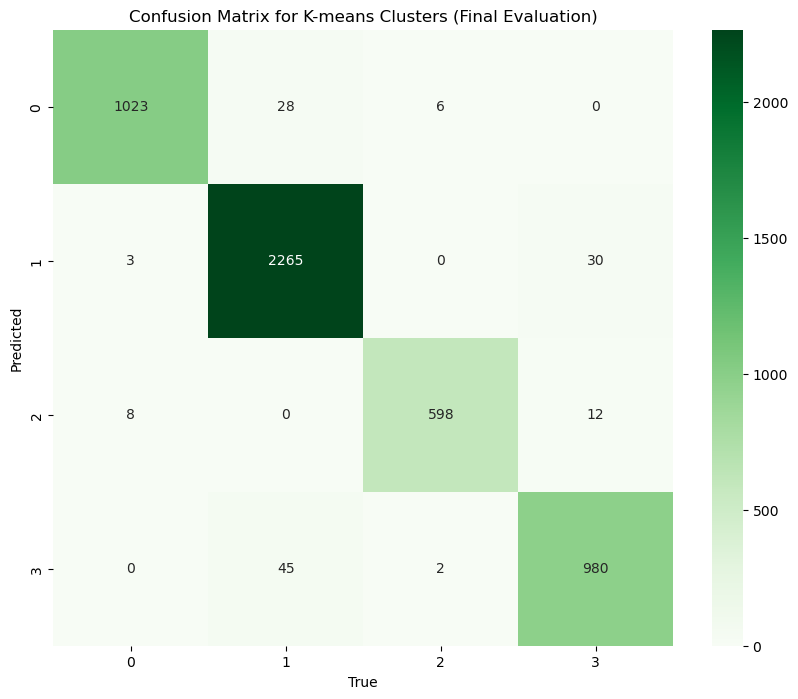

In [36]:
cf = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix for K-means Clusters (Final Evaluation)')
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.savefig('Heatmap Kmeans TEST.png')
plt.show()

In [37]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(X_test_norm)
y_test_pred_proba[0:10]

array([[0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.04492149, 0.95507851, 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.8264015 , 0.1735985 ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        , 0.        ]])

In [38]:
y_test_pred[0:10]

array(['mid-high energy, low inst', 'mid-high energy, high inst',
       'mid-high energy, low inst', 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, low inst',
       'mid-low energy, high inst', 'mid-low energy, high inst',
       'mid-low energy, low inst', 'mid-high energy, low inst'],
      dtype=object)

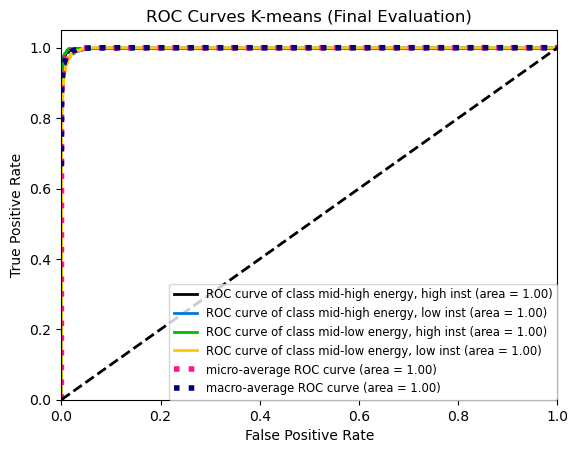

In [76]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_test, y_test_pred_proba)
plt.title('ROC Curves K-means (Final Evaluation)')
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0), borderaxespad=0, fontsize='small')
plt.savefig('Kmeans ROC Final')
plt.show()

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.9989764152873262

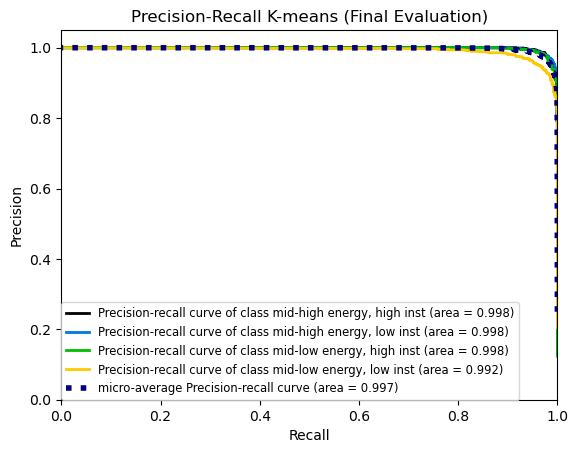

In [75]:
plot_precision_recall(y_test, y_test_pred_proba)
plt.title('Precision-Recall K-means (Final Evaluation)')
plt.legend(loc='lower left', bbox_to_anchor=(0, 0), borderaxespad=0, fontsize='small')
#plt.savefig('Kmeans P-R Final')
plt.show()

#### Repeated Holdout

In [42]:
N = 50
err = 0

for i in range(N):
    # stratified holdout
    X_rh_train, X_rh_val, y_rh_train, y_rh_val = train_test_split(X_train, y_train, test_size=0.333333333333333333, stratify=y_train)
    
    # normalize train set
    norm.fit(X_rh_train)
    X_rh_train_norm = norm.transform(X_rh_train)
    X_rh_val_norm = norm.transform(X_rh_val)

    # initialize and fit classifier
    clf = KNeighborsClassifier(n_neighbors=24, metric="cityblock", weights="distance")
    clf.fit(X_rh_train_norm, y_rh_train)

    # computing error
    acc = clf.score(X_test_norm, y_test)
    err += 1 - acc

print("Overall error estimate:", err/N)

Overall error estimate: 0.02837600000000001


#### Cross-validation
https://scikit-learn.org/stable/modules/cross_validation.html

In [43]:
from sklearn.model_selection import cross_val_score
k = 10

In [44]:
# initialize classifier
clf = KNeighborsClassifier(n_neighbors=24, metric="cityblock", weights="distance")

scores = cross_val_score(clf, X_train_norm, y_train, cv=k)
scores

array([0.974     , 0.97133333, 0.968     , 0.97266667, 0.972     ,
       0.97666667, 0.97666667, 0.974     , 0.96533333, 0.96666667])

In [45]:
print("Overall error estimate:", 1 - scores.mean())

Overall error estimate: 0.02826666666666655


In [46]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.9717 (+/- 0.00)


In [47]:
# scoring default is accuracy
cross_val_score(clf, X_train_norm, y_train, cv=k, scoring='f1_macro')

array([0.97247033, 0.96938378, 0.96689613, 0.9712494 , 0.96893566,
       0.97548079, 0.97690264, 0.97144414, 0.9627028 , 0.96432034])

### Hyperparameters Tuning

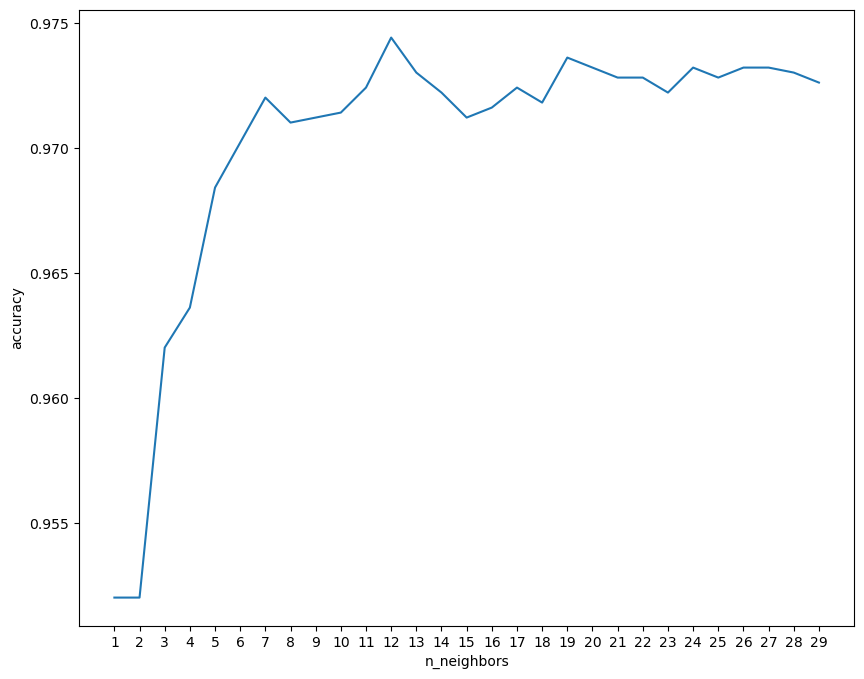

In [48]:
n_neighbors = range(1,30)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="cityblock", weights="distance")
    clf.fit(X_train_norm, y_train)
    scores.append(clf.score(X_test_norm, y_test))

plt.figure(figsize=(10, 8))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

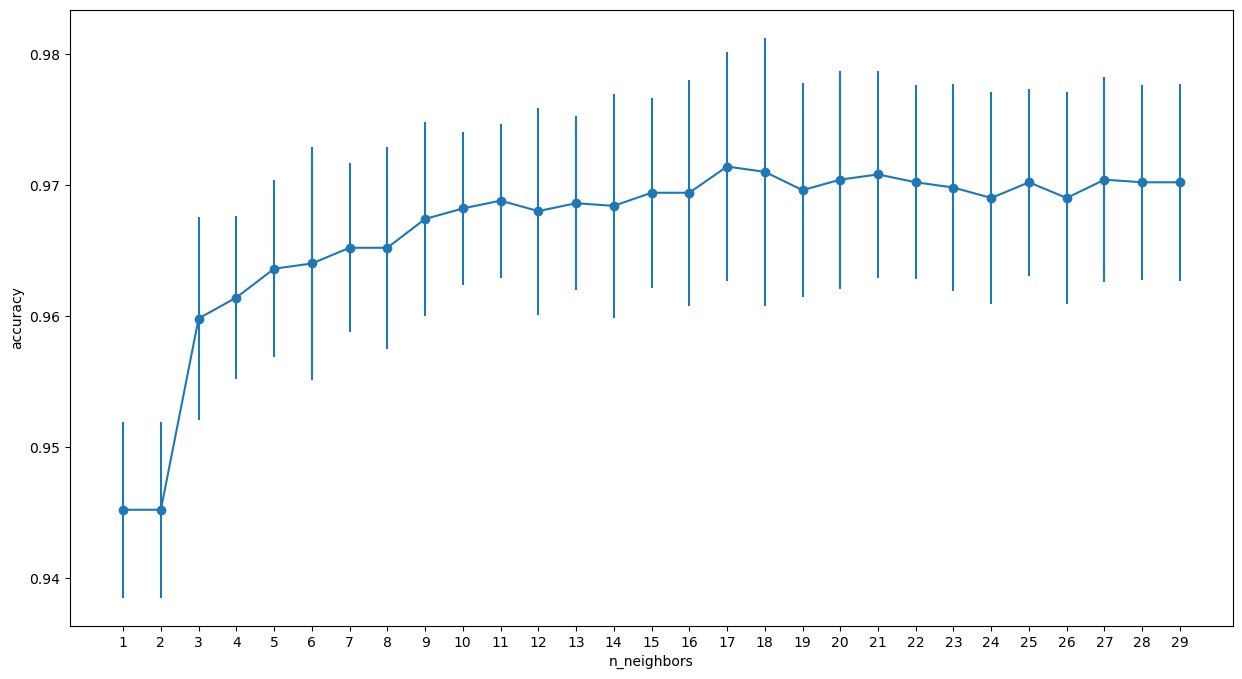

In [49]:
n_neighbors = range(1,30)
avg_scores = list()
std_scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="cityblock", weights="distance")
    scores = cross_val_score(clf, X_test_norm, y_test, cv=k)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

#plt.plot(avg_scores)
plt.figure(figsize=(15, 8))
plt.errorbar(range(len(n_neighbors)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [50]:
clf = KNeighborsClassifier(n_neighbors=24, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)
y_test_pred = clf.predict(X_test_norm)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.9732


#### Grid Search

In [51]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

%%time
param_grid = {
    "n_neighbors": np.arange(1, X_train.shape[0]//2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_train_norm, y_train)
clf = grid.best_estimator_

print(grid.best_params_, grid.best_score_)

y_test_pred = clf.predict(X_test_norm)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

clf.score(X_test_norm, y_test)

# grid.cv_results_

results = pd.DataFrame(grid.cv_results_)
results

results["metric_weight"] = results["param_metric"] + ", " + results["param_weights"]

sns.lineplot(
    data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight"
)

### Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

#### Gaussian

In [53]:
clf = GaussianNB()

In [54]:
%%time
clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 17.5 ms


GaussianNB()

In [55]:
y_pred = clf.predict(X_test)
y_pred

array(['mid-high energy, low inst', 'mid-high energy, low inst',
       'mid-high energy, low inst', ..., 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, low inst'],
      dtype='<U26')

In [56]:
print(classification_report(y_test, y_pred))

                            precision    recall  f1-score   support

mid-high energy, high inst       0.62      0.17      0.27      1057
 mid-high energy, low inst       0.58      0.95      0.72      2298
 mid-low energy, high inst       0.75      0.44      0.56       618
  mid-low energy, low inst       0.39      0.23      0.29      1027

                  accuracy                           0.57      5000
                 macro avg       0.58      0.45      0.46      5000
              weighted avg       0.57      0.57      0.52      5000



In [57]:
clf.predict_proba(X_test)

array([[0.13283016, 0.65617243, 0.01064757, 0.20034984],
       [0.25402457, 0.60181638, 0.01326164, 0.13089742],
       [0.13410738, 0.55920152, 0.02556693, 0.28112417],
       ...,
       [0.15844633, 0.68834618, 0.00673335, 0.14647414],
       [0.24989233, 0.51094566, 0.05877956, 0.18038245],
       [0.14389795, 0.77351211, 0.00368166, 0.07890828]])

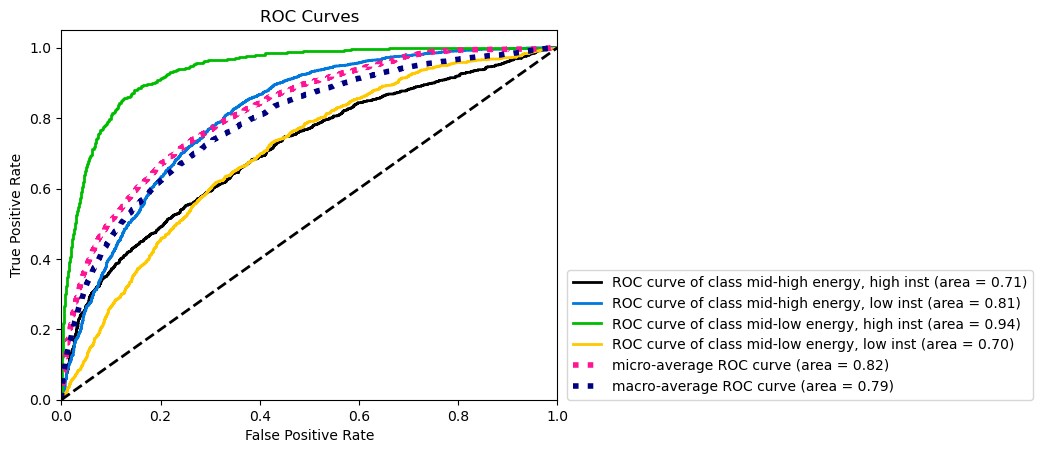

0.7881714959897239


In [58]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='lower left', bbox_to_anchor=(1.02, 0), borderaxespad=0)
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))

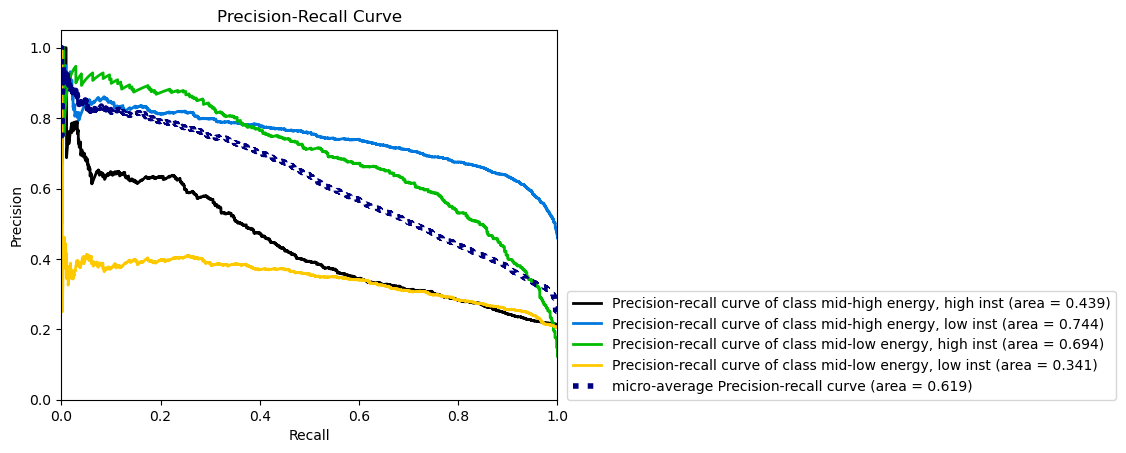

In [59]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.legend(loc='lower left', bbox_to_anchor=(1.02, 0), borderaxespad=0)

plt.show()

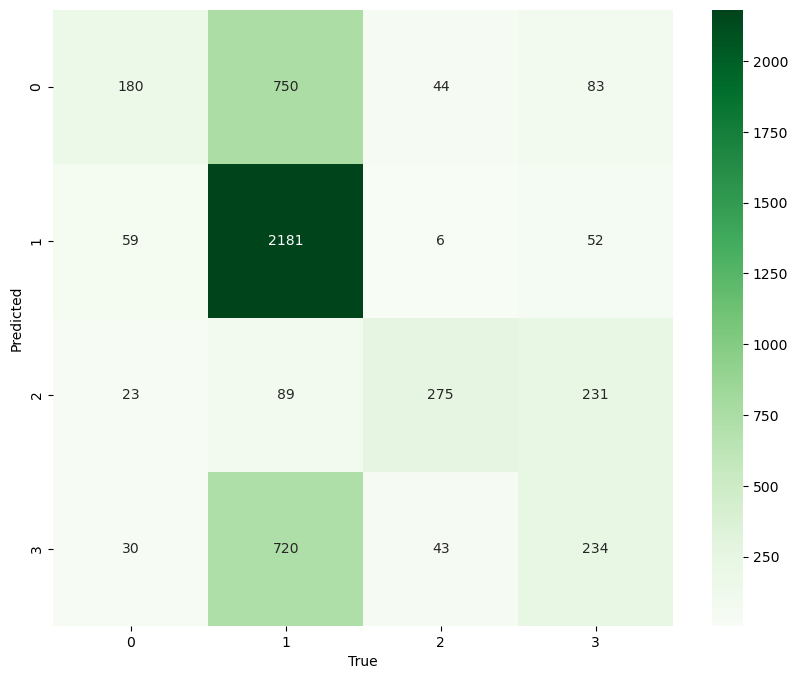

In [60]:
cf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [77]:
# score: Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

0.574

In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.574


In [80]:
y_test

array(['mid-high energy, low inst', 'mid-high energy, high inst',
       'mid-high energy, low inst', ..., 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, high inst'],
      dtype=object)

In [81]:
y_pred

array(['mid-high energy, low inst', 'mid-high energy, low inst',
       'mid-high energy, low inst', ..., 'mid-high energy, low inst',
       'mid-high energy, low inst', 'mid-high energy, low inst'],
      dtype='<U26')